#Data Load & Create Features

In [69]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# 설정
USE_SUBLABEL = False #동일한 페이지 내의 서브페이지를 같은 것으로 인식
URL_PER_SITE = 10
TOTAL_URLS_MON = 950  # Monitored 데이터 URL 수
TOTAL_URLS_UNMON = 3000  # Unmonitored 데이터 URL 수

# Number of Incoming/Outgoing Packets
def count_in_out_packets(data):
    num_incoming = sum(1 for c in data if c > 0)  # Positive indicates incoming
    num_outgoing = sum(1 for c in data if c < 0)  # Negative indicates outgoing
    return num_incoming, num_outgoing


# Number of Incoming/Outgoing Packets as a Fraction of Total
def fraction_in_out_packets(num_incoming, num_outgoing):
    total_packets = num_incoming + num_outgoing
    if total_packets == 0:  # To avoid division by zero
        return 0, 0
    fraction_incoming = num_incoming / total_packets
    fraction_outgoing = num_outgoing / total_packets
    return fraction_incoming, fraction_outgoing


# Standard Deviation of Outgoing Packet Ordering List
def std_dev_outgoing_packets(data):
    outgoing_sizes = [abs(c) * 512 for c in data if c < 0]  # Only outgoing packets
    if len(outgoing_sizes) > 1:
        return np.std(outgoing_sizes)
    return 0


# Sum of All Items in the Alternative Concentration Feature List
def sum_alternative_concentration(size_seq):
    return sum(size_seq)


# Average of the Outgoing and Total Number of Packets
def avg_outgoing_and_total_packets(num_incoming, num_outgoing):
    total_packets = num_incoming + num_outgoing
    if total_packets == 0:  # To avoid division by zero
        return 0
    avg = (num_outgoing + total_packets) / 2
    return avg


# Sum of Incoming, Outgoing, and Total Number of Packets
def sum_in_out_total_packets(num_incoming, num_outgoing):
    return num_incoming + num_outgoing


# Sum of Alternative Number of Packets per Second
def sum_packets_per_second(time_seq, size_seq):
    total_time = sum(time_seq)
    if total_time == 0:
        return 0
    total_packets = sum(size_seq)
    return total_packets / total_time

# Total Number of Packets
def total_packets(num_incoming, num_outgoing):
    return num_incoming + num_outgoing

# Google 드라이브 마운트
drive.mount('/content/drive')

# 파일 경로 설정 (드라이브에서 파일 경로 확인 필요)
mon_file = '/content/drive/MyDrive/mon_standard.pkl'
unmon_file = '/content/drive/MyDrive/unmon_standard10_3000.pkl'

# 데이터 로드
with open(mon_file, 'rb') as f:
    mon_data = pickle.load(f)
with open(unmon_file, 'rb') as f:
    unmon_data = pickle.load(f)

# Monitored 데이터 변환
X1_mon, X2_mon, X3_mon, X4_mon, X5_mon, X6_mon, X7_mon, X8_mon, X9_mon, y_mon = [], [], [], [], [], [], [], [], [], []

for i in range(TOTAL_URLS_MON):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE

    for sample in mon_data[i]:
        size_seq = []
        time_seq = []
        burst_seq = []
        cumulative_sum = 0
        prev_size = 0

        for c in sample:
            dr = 1 if c > 0 else -1
            size = dr * 512
            size_seq.append(size)
            time_seq.append(abs(c))

            # Burst Sequence 계산
            if size != prev_size:
                burst_seq.append(size)
            else:
                burst_seq.append(0)
            prev_size = size

        # 누적 크기 계산
        cumulative_size = calculate_cumulative_size(size_seq)

        # 기타 특징 계산
        num_incoming, num_outgoing = count_in_out_packets(sample)
        fraction_incoming, fraction_outgoing = fraction_in_out_packets(num_incoming, num_outgoing)
        std_dev_outgoing = std_dev_outgoing_packets(sample)
        sum_alternative = sum_alternative_concentration(size_seq)
        avg_outgoing_total = avg_outgoing_and_total_packets(num_incoming, num_outgoing)

        # List 추가
        X1_mon.append(time_seq)
        X2_mon.append(size_seq)
        X3_mon.append(cumulative_size)
        X4_mon.append(burst_seq)
        X5_mon.append(fraction_incoming)
        X6_mon.append(fraction_outgoing)
        X7_mon.append(std_dev_outgoing)
        X8_mon.append(sum_alternative)
        X9_mon.append(avg_outgoing_total)
        y_mon.append(label)

# Unmonitored 데이터 변환
X1_unmon, X2_unmon, X3_unmon, X4_unmon, X5_unmon, X6_unmon, X7_unmon, X8_unmon, X9_unmon = [], [], [], [], [], [], [], [], []

for sample in unmon_data:
    size_seq = []
    time_seq = []
    burst_seq = []
    cumulative_sum = 0
    prev_size = 0

    for c in sample:
        dr = 1 if c > 0 else -1
        size = dr * 512
        size_seq.append(size)
        time_seq.append(abs(c))

        # Burst Sequence 계산
        if size != prev_size:
            burst_seq.append(size)
        else:
            burst_seq.append(0)
        prev_size = size

    # 누적 크기 계산
    cumulative_size = calculate_cumulative_size(size_seq)

    # 기타 특징 계산
    num_incoming, num_outgoing = count_in_out_packets(sample)
    fraction_incoming, fraction_outgoing = fraction_in_out_packets(num_incoming, num_outgoing)
    std_dev_outgoing = std_dev_outgoing_packets(sample)
    sum_alternative = sum_alternative_concentration(size_seq)
    avg_outgoing_total = avg_outgoing_and_total_packets(num_incoming, num_outgoing)

    # List 추가
    X1_unmon.append(time_seq)
    X2_unmon.append(size_seq)
    X3_unmon.append(cumulative_size)
    X4_unmon.append(burst_seq)
    X5_unmon.append(fraction_incoming)
    X6_unmon.append(fraction_outgoing)
    X7_unmon.append(std_dev_outgoing)
    X8_unmon.append(sum_alternative)
    X9_unmon.append(avg_outgoing_total)

# Monitored 데이터프레임
mon_df = pd.DataFrame({
    'Sum Timestamps (X1)': [sum(seq) for seq in X1_mon],
    'Sum Direction * Size (X2)': [sum(seq) for seq in X2_mon],
    'Cumulative Size Sum (X3)': [sum(seq) for seq in X3_mon],
    'Fraction Incoming (X5)': X5_mon,
    'Fraction Outgoing (X6)': X6_mon,
    'Std Dev Outgoing (X7)': X7_mon,
    'Sum Alternative (X8)': X8_mon,
    'Average Outgoing & Total (X9)': X9_mon,
    'Label': ['Monitored'] * len(X1_mon)
})

# Unmonitored 데이터프레임
unmon_df = pd.DataFrame({
    'Sum Timestamps (X1)': [sum(seq) for seq in X1_unmon],
    'Sum Direction * Size (X2)': [sum(seq) for seq in X2_unmon],
    'Cumulative Size Sum (X3)': [sum(seq) for seq in X3_unmon],
    'Fraction Incoming (X5)': X5_unmon,
    'Fraction Outgoing (X6)': X6_unmon,
    'Std Dev Outgoing (X7)': X7_unmon,
    'Sum Alternative (X8)': X8_unmon,
    'Average Outgoing & Total (X9)': X9_unmon,
    'Label': ['Unmonitored'] * len(X1_unmon)
})

# 데이터 병합
data = pd.concat([mon_df, unmon_df], ignore_index=True)

# 결과 확인
print("데이터 로드 및 변환 완료!")
print(data.head())
print(data['Label'].value_counts())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
데이터 로드 및 변환 완료!
   Sum Timestamps (X1)  Sum Direction * Size (X2)  Cumulative Size Sum (X3)  \
0              6132.68                    -603648                -437039616   
1              2388.92                    -183296                 -44916224   
2              7454.02                    -574464                -403351040   
3              8669.51                    -615424                -457457152   
4              6606.61                    -602112                -433843712   

   Fraction Incoming (X5)  Fraction Outgoing (X6)  Std Dev Outgoing (X7)  \
0                0.085211                0.914789             517.967047   
1                0.154739                0.845261             671.029081   
2                0.086957                0.913043             541.675995   
3                0.084429                0.915571             793.025790   


#Random Forest Model_Openworld (#1~#9 features used)

In [71]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Monitored 및 Unmonitored 데이터 준비
mon_features = pd.DataFrame({
    'Packet Sizes Sequence (X1)': X1_mon,
    'Packet Timestamps Sequence (X2)': X2_mon,
    'Cumulative Packet Sizes (X3)': X3_mon,
    'Fraction Outgoing (X6)': X6_mon,
    'Std Dev Outgoing (X7)': X7_mon,
    'Sum Alternative (X8)': X8_mon,
    'Average Outgoing & Total (X9)': X9_mon,
    'Label': y_mon  # y_mon은 binary(-1, 1) 또는 multi-class(0~94)로 지정됨
})

unmon_features = pd.DataFrame({
    'Packet Sizes Sequence (X1)': X1_unmon,
    'Packet Timestamps Sequence (X2)': X2_unmon,
    'Cumulative Packet Sizes (X3)': X3_unmon,
    'Fraction Outgoing (X6)': X6_unmon,
    'Std Dev Outgoing (X7)': X7_unmon,
    'Sum Alternative (X8)': X8_unmon,
    'Average Outgoing & Total (X9)': X9_unmon,
    'Label': [-1] * len(X1_unmon)  # Unmonitored 웹 사이트는 '-1'로 레이블링
})

# Monitored와 Unmonitored 데이터 병합
data = pd.concat([mon_features, unmon_features], ignore_index=True)

# Step 2: 특징과 레이블 분리
X = data.drop('Label', axis=1)
y_binary = data['Label'].apply(lambda x: 1 if x != -1 else -1)  # Binary: Monitored(1), Unmonitored(-1)
y_multiclass = data['Label']  # Multi-class: Monitored(0~94), Unmonitored(-1)

# Step 3: 데이터 분할
X_train, X_test, y_binary_train, y_binary_test = train_test_split(X, y_binary, test_size=0.3, random_state=42)
_, _, y_multiclass_train, y_multiclass_test = train_test_split(X, y_multiclass, test_size=0.3, random_state=42)

# Step 4: 시퀀스 요약 통계로 변환
def summarize_sequence_features(df, columns):
    for col in columns:
        df[col + '_mean'] = df[col].apply(lambda x: np.mean(x) if isinstance(x, list) else x)
        df[col + '_std'] = df[col].apply(lambda x: np.std(x) if isinstance(x, list) else x)
        df[col + '_max'] = df[col].apply(lambda x: np.max(x) if isinstance(x, list) else x)
        df[col + '_min'] = df[col].apply(lambda x: np.min(x) if isinstance(x, list) else x)
        df.drop(col, axis=1, inplace=True)
    return df

X_train = summarize_sequence_features(X_train, ['Packet Sizes Sequence (X1)', 'Packet Timestamps Sequence (X2)', 'Cumulative Packet Sizes (X3)'])
X_test = summarize_sequence_features(X_test, ['Packet Sizes Sequence (X1)', 'Packet Timestamps Sequence (X2)', 'Cumulative Packet Sizes (X3)'])

# Step 5: 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: 랜덤포레스트 모델 생성 및 학습
def train_and_evaluate(X_train, X_test, y_train, y_test, mode):
    print(f"\n=== {mode.capitalize()} Classification ===")
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        max_features='sqrt',
        random_state=42,
        class_weight='balanced'
    )

    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    # 성능 평가
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# Step 7: Binary와 Multi-class 모델 학습 및 평가
train_and_evaluate(X_train_scaled, X_test_scaled, y_binary_train, y_binary_test, mode='binary')
train_and_evaluate(X_train_scaled, X_test_scaled, y_multiclass_train, y_multiclass_test, mode='multi-class')



=== Binary Classification ===
Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

          -1       0.98      0.65      0.78       882
           1       0.95      1.00      0.97      5718

    accuracy                           0.95      6600
   macro avg       0.96      0.82      0.88      6600
weighted avg       0.95      0.95      0.95      6600


=== Multi-class Classification ===
Accuracy: 0.65
Classification Report:
              precision    recall  f1-score   support

          -1       0.51      0.55      0.53       882
           0       0.63      0.55      0.59        58
           1       0.53      0.30      0.38        60
           2       0.86      0.89      0.87        62
           3       0.53      0.57      0.55        46
           4       0.57      0.78      0.66        50
           5       0.88      0.83      0.85        60
           6       0.85      0.90      0.88        63
           7       0.53      0.60      0.56

#Random Forest - Closed World _ Select 1,2,3,5,6,7,8,9 feature


Closed-world Experiment Performance:
Accuracy: 0.67
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.56      0.63        62
           1       0.41      0.25      0.31        59
           2       0.71      0.91      0.80        55
           3       0.53      0.76      0.62        46
           4       0.70      0.74      0.72        53
           5       0.79      0.79      0.79        63
           6       0.74      0.94      0.83        65
           7       0.71      0.58      0.64        64
           8       0.71      0.68      0.70        59
           9       0.45      0.62      0.52        47
          10       0.77      0.61      0.68        66
          11       0.62      0.60      0.61        57
          12       0.83      0.85      0.84        59
          13       0.50      0.41      0.45        54
          14       0.64      0.40      0.49        58
          15       0.68      0.78      0.72        59
     

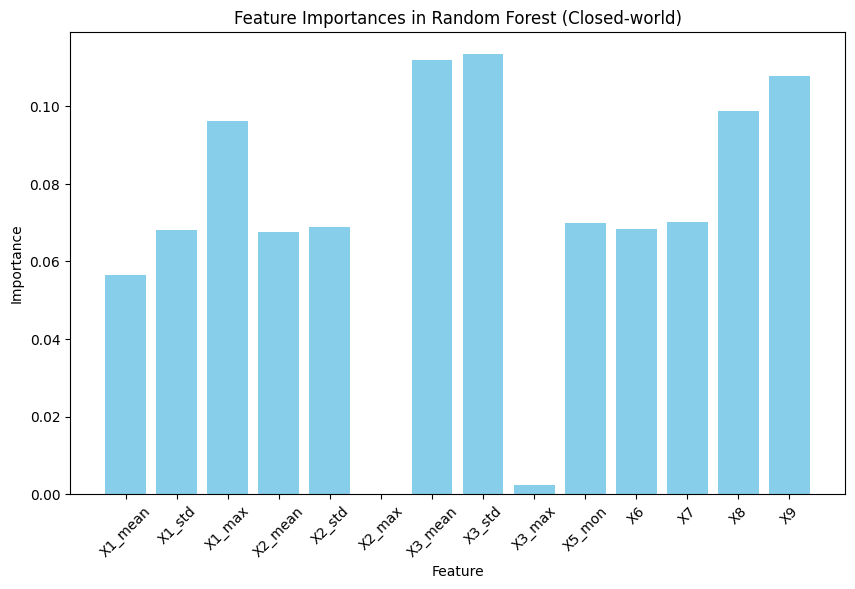

In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 시퀀스 데이터를 요약하는 함수
def summarize_features(sequence):
    if len(sequence) == 0:
        return {'mean': 0, 'std': 0, 'max': 0}  # 빈 시퀀스 처리
    return {
        'mean': np.mean(sequence),
        'std': np.std(sequence),
        'max': np.max(sequence)
    }

# Step 1: Monitored 데이터 준비 (Packet Sizes Sequence 등 포함)
mon_features = pd.DataFrame({
    'X1_mean': [summarize_features(seq)['mean'] for seq in X1_mon],
    'X1_std': [summarize_features(seq)['std'] for seq in X1_mon],
    'X1_max': [summarize_features(seq)['max'] for seq in X1_mon],
    'X2_mean': [summarize_features(seq)['mean'] for seq in X2_mon],
    'X2_std': [summarize_features(seq)['std'] for seq in X2_mon],
    'X2_max': [summarize_features(seq)['max'] for seq in X2_mon],
    'X3_mean': [summarize_features(seq)['mean'] for seq in X3_mon],
    'X3_std': [summarize_features(seq)['std'] for seq in X3_mon],
    'X3_max': [summarize_features(seq)['max'] for seq in X3_mon],
    'X5_mon': X5_mon,
    'X6': X6_mon,
    'X7': X7_mon,
    'X8': X8_mon,
    'X9': X9_mon,
})

# Monitored 레이블 추가 (0 ~ 94)
mon_features['Label'] = y_mon  # y_mon은 0~94의 레이블을 가짐

# Step 2: 특징과 레이블 분리
X = mon_features.drop('Label', axis=1)  # 특징 데이터
y = mon_features['Label']  # 레이블 데이터 (0 ~ 94)

# Step 3: 데이터 분할 (학습 데이터와 테스트 데이터)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: 랜덤포레스트 모델 생성 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Step 5: 테스트 데이터로 예측
y_pred = rf_model.predict(X_test)

# 정확도 및 성능 평가
accuracy = accuracy_score(y_test, y_pred)

print("\nClosed-world Experiment Performance:")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 6: 특징 중요도 계산 및 시각화
feature_importances = rf_model.feature_importances_

# 특징 중요도 시각화
plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importances, color='skyblue')
plt.title("Feature Importances in Random Forest (Closed-world)")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.show()


#SVM_OPENWORLD

In [72]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Monitored 및 Unmonitored 데이터 준비
mon_features = pd.DataFrame({
    'Packet Sizes Sequence (X1)': X1_mon,
    'Packet Timestamps Sequence (X2)': X2_mon,
    'Cumulative Packet Sizes (X3)': X3_mon,
    'Fraction Outgoing (X6)': X6_mon,
    'Std Dev Outgoing (X7)': X7_mon,
    'Sum Alternative (X8)': X8_mon,
    'Average Outgoing & Total (X9)': X9_mon,
    'Label': y_mon
})

unmon_features = pd.DataFrame({
    'Packet Sizes Sequence (X1)': X1_unmon,
    'Packet Timestamps Sequence (X2)': X2_unmon,
    'Cumulative Packet Sizes (X3)': X3_unmon,
    'Fraction Outgoing (X6)': X6_unmon,
    'Std Dev Outgoing (X7)': X7_unmon,
    'Sum Alternative (X8)': X8_unmon,
    'Average Outgoing & Total (X9)': X9_unmon,
    'Label': [-1] * len(X1_unmon)
})

# Monitored와 Unmonitored 데이터 병합
data = pd.concat([mon_features, unmon_features], ignore_index=True)

# 특징과 레이블 분리
X = data.drop('Label', axis=1)
y = data['Label']

# === Binary Classification ===
# Binary 레이블 생성: monitored(0~94)는 1, unmonitored(-1)는 -1
y_binary = y.apply(lambda x: 1 if x != -1 else -1)

# 데이터 분할
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_binary, test_size=0.3, random_state=42)

# === Multi-Class Classification ===
# Multi-Class 레이블 생성: monitored(0~94) 그대로 사용, unmonitored는 -1
y_multiclass = y

# 데이터 분할
X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(X, y_multiclass, test_size=0.3, random_state=42)

# 시퀀스 요약 통계로 변환
def summarize_sequence_features(df, columns):
    for col in columns:
        df[col + '_mean'] = df[col].apply(lambda x: np.mean(x) if isinstance(x, list) else x)
        df[col + '_std'] = df[col].apply(lambda x: np.std(x) if isinstance(x, list) else 0)
        df[col + '_max'] = df[col].apply(lambda x: np.max(x) if isinstance(x, list) else x)
        df[col + '_min'] = df[col].apply(lambda x: np.min(x) if isinstance(x, list) else x)
        df.drop(col, axis=1, inplace=True)
    return df

X_train_bin = summarize_sequence_features(X_train_bin, ['Packet Sizes Sequence (X1)', 'Packet Timestamps Sequence (X2)', 'Cumulative Packet Sizes (X3)'])
X_test_bin = summarize_sequence_features(X_test_bin, ['Packet Sizes Sequence (X1)', 'Packet Timestamps Sequence (X2)', 'Cumulative Packet Sizes (X3)'])

X_train_mc = summarize_sequence_features(X_train_mc, ['Packet Sizes Sequence (X1)', 'Packet Timestamps Sequence (X2)', 'Cumulative Packet Sizes (X3)'])
X_test_mc = summarize_sequence_features(X_test_mc, ['Packet Sizes Sequence (X1)', 'Packet Timestamps Sequence (X2)', 'Cumulative Packet Sizes (X3)'])

# 데이터 스케일링
scaler = StandardScaler()
X_train_bin_scaled = scaler.fit_transform(X_train_bin)
X_test_bin_scaled = scaler.transform(X_test_bin)

X_train_mc_scaled = scaler.fit_transform(X_train_mc)
X_test_mc_scaled = scaler.transform(X_test_mc)

# SVM 모델 학습 (이진 분류)
svm_binary = SVC(kernel='linear', random_state=42, probability=True, class_weight='balanced')
svm_binary.fit(X_train_bin_scaled, y_train_bin)

# SVM 모델 학습 (다중 클래스 분류)
svm_multiclass = SVC(kernel='linear', random_state=42, probability=True, class_weight='balanced', decision_function_shape='ovr')
svm_multiclass.fit(X_train_mc_scaled, y_train_mc)

# 예측
y_pred_bin = svm_binary.predict(X_test_bin_scaled)
y_pred_mc = svm_multiclass.predict(X_test_mc_scaled)

# === Binary Classification (SVM) ===
print("\n=== Binary Classification (SVM) ===")
binary_accuracy = accuracy_score(y_test_bin, y_pred_bin)
print(f"Accuracy: {binary_accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test_bin, y_pred_bin))

# === Multi-Class Classification (SVM) ===
print("\n=== Multi-Class Classification (SVM) ===")
multi_accuracy = accuracy_score(y_test_mc, y_pred_mc)
print(f"Accuracy: {multi_accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test_mc, y_pred_mc))



=== Binary Classification (SVM) ===
Accuracy: 0.72
Classification Report:
              precision    recall  f1-score   support

          -1       0.23      0.48      0.31       882
           1       0.90      0.75      0.82      5718

    accuracy                           0.72      6600
   macro avg       0.57      0.62      0.57      6600
weighted avg       0.81      0.72      0.75      6600


=== Multi-Class Classification (SVM) ===
Accuracy: 0.27
Classification Report:
              precision    recall  f1-score   support

          -1       1.00      0.01      0.02       882
           0       0.83      0.09      0.16        58
           1       0.02      0.02      0.02        60
           2       0.14      0.35      0.20        62
           3       0.20      0.07      0.10        46
           4       0.12      0.08      0.10        50
           5       0.00      0.00      0.00        60
           6       0.33      0.73      0.46        63
           7       0.16      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Binary Classification ===
Confusion Matrix (Binary Classification):
[[ 426  456]
 [1414 4304]]

Classification Report (Binary Classification):
              precision    recall  f1-score   support

          -1       0.23      0.48      0.31       882
           1       0.90      0.75      0.82      5718

    accuracy                           0.72      6600
   macro avg       0.57      0.62      0.57      6600
weighted avg       0.81      0.72      0.75      6600



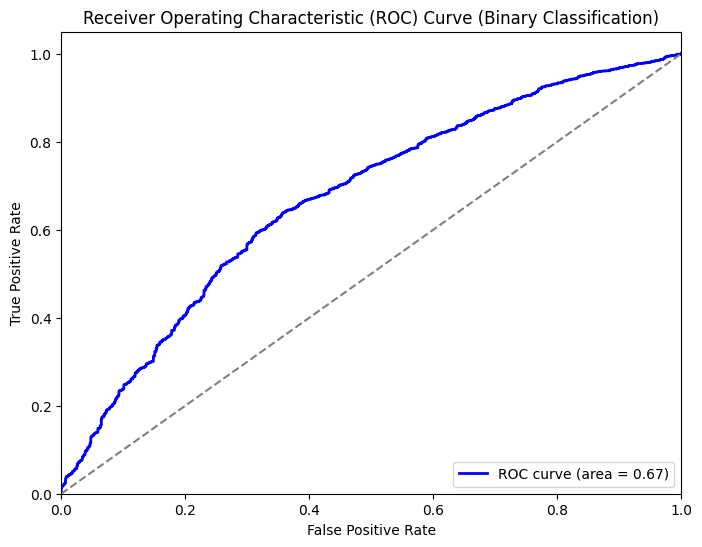


=== Multi-Class Classification ===
Confusion Matrix (Multi-Class Classification):
[[ 7  1  2 ...  0 14 33]
 [ 0  5  2 ...  0  1  7]
 [ 0  0  1 ...  0  0  1]
 ...
 [ 0  0  2 ...  0  0  2]
 [ 0  0  0 ...  0 32  0]
 [ 0  0  0 ...  0  0 17]]

Classification Report (Multi-Class Classification):
              precision    recall  f1-score   support

          -1       1.00      0.01      0.02       882
           0       0.83      0.09      0.16        58
           1       0.02      0.02      0.02        60
           2       0.14      0.35      0.20        62
           3       0.20      0.07      0.10        46
           4       0.12      0.08      0.10        50
           5       0.00      0.00      0.00        60
           6       0.33      0.73      0.46        63
           7       0.16      0.38      0.23        50
           8       0.09      0.04      0.05        54
           9       0.19      0.35      0.25        48
          10       0.12      0.01      0.03        67
     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: y should be a 1d array, got an array of shape (6600, 96) instead.

In [74]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# 예측 (y_pred_bin은 이진 분류 예측값, y_pred_mc는 다중 클래스 예측값)
# y_test는 실제 레이블, y_pred는 예측값입니다.

# 이진 분류 평가
print("\n=== Binary Classification ===")
cm_bin = confusion_matrix(y_test_bin, y_pred_bin)
print("Confusion Matrix (Binary Classification):")
print(cm_bin)

# 분류 성능 리포트 (Precision, Recall, F1-Score)
print("\nClassification Report (Binary Classification):")
print(classification_report(y_test_bin, y_pred_bin))

# ROC Curve (이진 분류)
fpr_bin, tpr_bin, thresholds_bin = roc_curve(y_test_bin, svm_binary.decision_function(X_test_bin_scaled))
roc_auc_bin = auc(fpr_bin, tpr_bin)

plt.figure(figsize=(8, 6))
plt.plot(fpr_bin, tpr_bin, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_bin:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Binary Classification)')
plt.legend(loc="lower right")
plt.show()